In [ ]:
# Restructure of program into functions 
    # Data structures for scrape/request log and support/resistance (predicted vs actual)
    # L2 update states applied to snapshot over a defined interval (15m, in sync with chart update)
        # Timestamp issue for 15m chart  
# One hot encoding into function       
# Function to reshape data into LSTM/GRU input shape             
# Further reshaping of input/test data for LSTM/GRU model 

In [1]:
# Imports
import pandas as pd
import numpy as np
import requests
import json
from json import loads
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Charting-specific imports
import matplotlib.finance
import matplotlib.ticker as ticker
from matplotlib.finance import candlestick_ohlc,candlestick2_ohlc
from matplotlib.finance import volume_overlay,volume_overlay2
from matplotlib.dates import  DateFormatter, epoch2num
    # https://matplotlib.org/api/finance_api.html#module-matplotlib.finance

# API-specific imports (local install)
import gdax
    # Python setup.py install with environment activaated to install/use
    # Do not use default gdax pip install package - that version of the package is currently broken

# Pymongo import for connection to local client DB
import pymongo
from pymongo import MongoClient

# Preprocessing Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from keras.utils import to_categorical 

# ML Imports 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras import backend as K

# autoSR() import requirements
from sklearn.cluster import MeanShift, estimate_bandwidth
from pandas_datareader import data, wb

###########################################################################
### Force Keras/TF to use CPU backend when GPU present by setting:
    # {'CPU' : 1, 'GPU' : 0}
    
#num_cores = 4
#config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        #inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        #device_count = {'CPU' : 1, 'GPU' : 1})
#session = tf.Session(config=config)
#K.set_session(session)
###########################################################################

# Import to check check for GPU availability for tensorflow backend
from tensorflow.python.client import device_lib

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Verify GPU availability for tensorflow backend
print(device_lib.list_local_devices())
print("==============================================")
print(K.tensorflow_backend._get_available_gpus())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15253135236911507133
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9222031934
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8813638440963105316
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


In [3]:
# Request log load
request_log_df= pd.read_csv("test_data/request_log.csv",dtype ={'epoch':object})
request_start = request_log_df['iso'][1]
request_end = request_log_df['iso'][0]
print(request_start)
print(request_end)

2018-04-17T00:55:03.354Z
2018-04-17T01:05:03.469Z


In [38]:
# Global variables

# Boolean to drop existing mongo collection/scrape upon scrape() init
dropFlag = False
# Boolean to set size_delta to l2update values for first update to snapshot
#firstUpdate = False
firstUpdate_bids = False
firstUpdate_asks = False
# Value to track if feature_creation_inital() was run
feature_creation_inital_run = False


In [5]:
# Connection establishment

# Establish connection to GDAX public endpoint
public_client = gdax.PublicClient()

# Mongo database and collection specification:
mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client.btcusd_db
btcusd_collection = db.btcusd_collection

In [6]:
# Function to start scrape process from websocket to mongodb instance
def scrape_start():
    
    # Drop existing collection from db if dropFlag == True (on new scrape):
    if 'btcusd_db' in mongo_client.database_names() and dropFlag is True:
        db['btcusd_db'].drop_collection('btcusd_collection')
        #print(mongo_client.database_names())
        #print(db.collection_names())
        
    # Start instance of websocket client for L2 Orderbook + L2 update data request and scrape
    wsClient = gdax.WebsocketClient(url="wss://ws-feed.gdax.com", 
                                products=["BTC-USD"],\
                                message_type="subscribe",\
                                channels =["level2"],\
                                mongo_collection=btcusd_collection,\
                                should_print=False)
    
    # Save request open time and start websocket
    time.sleep(4)
    request_time_start=public_client.get_time()
    wsClient.start()
    
    # scrape_time is variable for time between websocket connection start and end
        # Defined in seconds
        # i.e. 600 seconds = scrape running for 10 minutes
    scrape_time = 600

    time.sleep(scrape_time)
    # Save request close time and close websocket
    request_time_end=public_client.get_time()
    wsClient.close()
    
    # Append request times for open/close of websocket stream to dataframe, save to csv
    request_log_df = pd.DataFrame.from_dict({'request start':request_time_start,'request end':request_time_end},orient ='index')
    request_log_df.to_csv("raw_data/request_log.csv",header=True,encoding='utf-8',index =True)
   

In [7]:
# Function to load and parse data from Mongo into dataframes
def load_parse():
    
    #Collection specification (in database)
    input_data = db.btcusd_collection 
    
    # Create individual dataframes for main response types: snapshot, l2update
    snapshot = pd.DataFrame(list(input_data.find({'type':'snapshot'})))
    l2update = pd.DataFrame(list(input_data.find({'type':'l2update'})))
    
    ### snapshot  response load and parse ###
    
    # Extract asks/bid individual column of array of arrays into lists
    snapshot_asks = snapshot[['asks'][0]][0]
    snapshot_bids = snapshot[['bids'][0]][0]
    
    # Convert list (of array of arrays) into dataframe
    snapshot_asks_df =pd.DataFrame(snapshot_asks)
    snapshot_bids_df =pd.DataFrame(snapshot_bids)
    
    # Rename columns to snapshot array format:
        # snapshot array format: [price, size]
            # [side, price, size] format for one-hot encoding
        # Ask = sell price, bid = buy price
    snapshot_asks_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_bids_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_asks_df['side'] = "sell"
    snapshot_bids_df['side'] = "buy"
    cols =['side','price','size']
    snapshot_asks_df = snapshot_asks_df[cols]
    snapshot_bids_df = snapshot_bids_df[cols]
    
    ### L2 update response load and parse ###
    
    # Restucture l2update to have [side,price,size] from 'changes' column
    l2update_clean = l2update[['changes','time']]
          
    # Convert changes list of lists -> into array 
    l2_array = np.ravel(l2update_clean['changes']) 
    # Flatten the list and remove outer bracket:
    flattened = [val for sublist in l2_array for val in sublist]
        # Reference: https://stackoverflow.com/questions/11264684/flatten-list-of-lists?
    # Convert back to dataframe and combine with timestamps from l2update:
    changes_df= pd.DataFrame.from_records(flattened)
    # Add time column back to L2 update dataframe
    l2update_formatted = pd.concat([changes_df,l2update_clean['time']],1)
    # Rename columns for [side, price, size]:
    l2update_formatted.rename({0:"side",1:"price",2:"size"}, axis ='columns',inplace=True)
    
    # Save parsed data to csv (API -> Mongo -> Dataframe -> .csv)
    save_csv()
    
def save_csv():
    
    # Save data to .csv format in raw_data folder
    l2update_formatted.to_csv("raw_data/l2update.csv",header=True,encoding='utf-8',index =False)
    snapshot_asks_df.to_csv("raw_data/snapshot_asks.csv",header=True,encoding='utf-8',index =False)
    snapshot_bids_df.to_csv("raw_data/snapshot_bids.csv",header=True,encoding='utf-8',index =False)
    subscriptions.to_csv("raw_data/subscriptions.csv",header=True,encoding='utf-8',index =False)

In [8]:
# Function to read in data from csv into dataframes
    # Currently not working due to variable scope assignment for dataframes/reading in data from CSV

# Test data
#def data_read_test():
    
    # Read in test data for L2 orderbook state (bids + asks)
    # Read in test data for subsquent L2 orderbook update states (L2 updates to bid + asks)
    #snapshot_asks_df = pd.read_csv("test_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
    #snapshot_bids_df = pd.read_csv("test_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
    #l2update_df = pd.read_csv("test_data/l2update.csv", dtype ={'size':float})
    #request_log_df= pd.read_csv("test_data/request_log.csv")
    

    
    # Convert size column to float type for l2 updates
    #l2update_df['size'] = l2update_df['size'].apply(pd.to_numeric)
    #snapshot_bids_df['size_delta'] = snapshot_bids_df['size_delta'].apply(pd.to_numeric)

# Raw data
#def data_read_raw():
    
    # Read in test data for L2 orderbook state (bids + asks)
    # Read in test data for subsquent L2 orderbook update states (L2 updates to bid + asks)
    #snapshot_asks_df = pd.read_csv("raw_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
    #snapshot_bids_df = pd.read_csv("raw_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
    #l2update_df = pd.read_csv("raw_data/l2update.csv", dtype ={'size':float})
    #request_log_df= pd.read_csv("raw_data/request_log.csv")
    
    # Convert size column to float type for l2 updates
    #l2update_df['size'] = l2update_df['size'].apply(pd.to_numeric)
    #snapshot_bids_df['size_delta'] = snapshot_bids_df['size_delta'].apply(pd.to_numeric)

In [39]:
###########################################################################

# Section to read in data from csv (definition scope of functions above not working for assignment:)
    # Load in test data for development/debugging

snapshot_asks_df = pd.read_csv("test_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
snapshot_bids_df = pd.read_csv("test_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
l2update_df = pd.read_csv("test_data/l2update.csv", dtype ={'size':float})
request_log_df= pd.read_csv("test_data/request_log.csv")

###########################################################################

In [22]:
##### Request 15minute chart data #####

#def chart_15m_request(request_log_df):

request_start = request_log_df['iso'][1]
request_end = request_log_df['iso'][0]

# Request 15 minutes of candlestick (open high low close) data from API
    # start time must be in ISO 8601 format for get_product_historic_rates()
chart_15m = public_client.get_product_historic_rates('BTC-USD', start =request_start, granularity=60)

# Convert chart data response into dataframes
chart_15m_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,"close", "volume"])

# Reorder columns according to label order required by matplotlib finance package
chart_15m_df = chart_15m_df[["time","open","high","low","close","volume"]]

# Reverse/sort timestamp order (without reversal chart labels/axis will be out of order)
chart_15m_df.sort_values(by='time',axis=0, inplace =True)

#Convert/sort time to datetime object (for matplotlib chart format requirement)
chart_15m_df['time'] =pd.to_datetime(chart_15m_df['time'],unit='s')
    
    

In [23]:
# Auto support/resistance adapted into function 
    # Source: Adapted from https://github.com/nakulnayyar/SupResGenerator
    # Takes dataframe object with open/high/low/close values 
        # Returns list of auto-generated support and resistance levels for price action
def autoSR(dataframe):
    data = chart_15m_df.as_matrix(columns=['close'])
    data2 = data[:len(data)*1]
    bandwidth = estimate_bandwidth(data2, quantile=0.1, n_samples=100)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data2)
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
            my_members = ms.labels_ == k
            values = data[my_members, 0]    
            ml_results.append(min(values))
            ml_results.append(max(values))
            # Remove duplicate S/R level values
            # Using sets
            ml_set =set(ml_results)
            ml_results = list(ml_set)
            # Sort values before return output 
            ml_results.sort()
            
    return ml_results

In [24]:
def generate_chart(dataframe):
    
    dataframe = chart_15m_df 
    
    # Generate chart of past 15 minutes with autogenerated support and resistance levels:
    fig, ax = plt.subplots(figsize=(20, 10)
                         )
    candlestick2_ohlc(ax,chart_15m_df['open'],chart_15m_df['high'],chart_15m_df['low'],chart_15m_df['close'],width=2,\
                      colorup='k',colordown='r',alpha=.5)
    ax.set_xticklabels(chart_15m_df['time'] ,rotation=30)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(17))
        # n + 2 for proper labe set at 20,18 chart size
        # 15 + 2 =17
    plt.yticks(np.arange(int(min(chart_15m_df['low'])-5), max(chart_15m_df['high'])+10, 5))
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    #ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.tick_params(axis='y', pad=10)
    ax.grid(which='major', linestyle='--', linewidth='0.1', color='b')
    matplotlib.pyplot.title("15 Min BTC/USD with Support/Resistance Levels")
    
    # Add S/R labels to right side of chart
    ml_results = autoSR(chart_15m_df)
    for k in ml_results:
        plt.axhline(y=k)

    #plt.tight_layout()
    return plt.show()
    #return plt.show(), ml_results

In [54]:
# create and set inital/placeholder values for size_delta, position, and sr_prox_value/line input features 
    # run once upon new scrape only
def feature_creation_inital():
    if feature_creation_inital_run == False:
        # Set inital size delta l2 snapshot - use decimal point to force as float
        snapshot_asks_df['size_delta'] = 0.0
        snapshot_bids_df['size_delta'] = 0.0

        # Set inital position for l2 snapshot
        snapshot_asks_df['position'] = snapshot_asks_df.index +1
        snapshot_bids_df['position'] = snapshot_bids_df.index +1

        # Reverse index for sell/asks
        # snapshot_asks_df =snapshot_asks_df[::-1]
        # Reverse inital position indicator for bids/buy side
        rev = snapshot_bids_df['position'].values * -1
        snapshot_bids_df['position'] = rev

        # Set inital proximity value and inital value for nearest prox line
        snapshot_asks_df['sr_prox_value'] = 0
        snapshot_asks_df['sr_prox_line'] = 0
        snapshot_bids_df['sr_prox_value'] = 0
        snapshot_bids_df['sr_prox_line'] = 0

        # Set feature_creation_inital_run flag to True once run
        feature_creation_inital_run = True
        
    elif feature_creation_inital_run == True:
        # Required syntax for logical operator/ if-else structure, but does nothing as a result
        # i.e., a "pass"
        pass
        

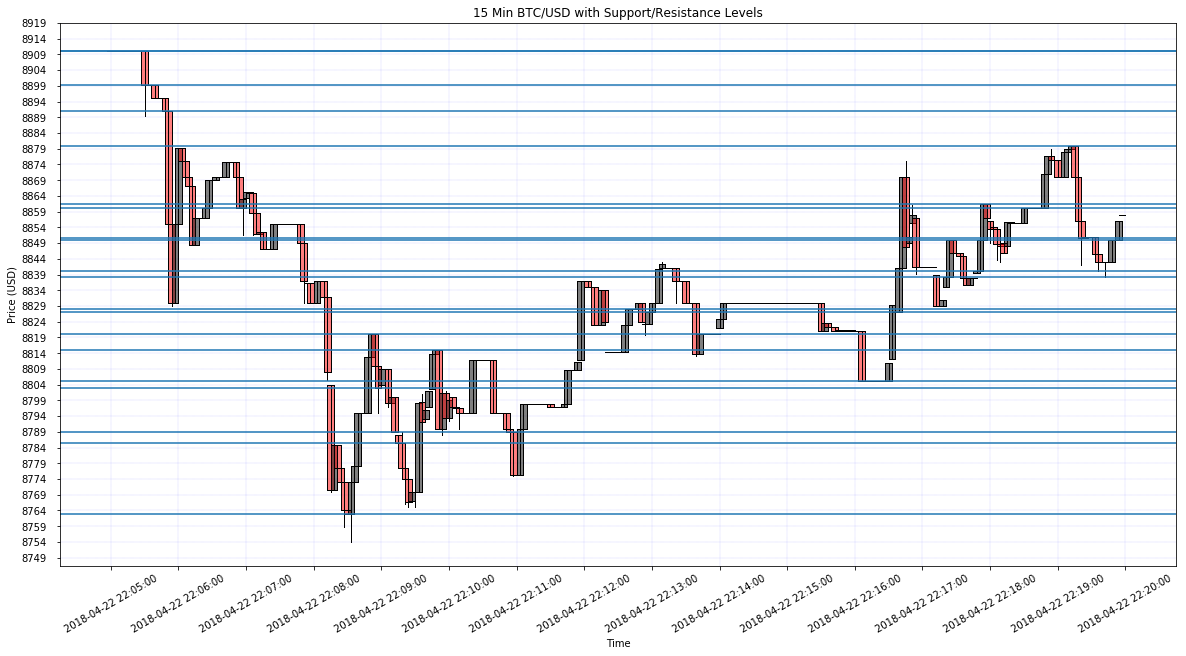

In [26]:
generate_chart(chart_15m_df)

In [42]:
###########################################################################
###########################################################################

# Debugging

In [47]:
# Assignment of ml_results from function:
ml_results = autoSR(chart_15m_df)
autoSR(chart_15m_df)

[8762.97,
 8785.48,
 8788.89,
 8803.0,
 8805.0,
 8815.01,
 8819.99,
 8827.02,
 8827.9,
 8838.15,
 8840.0,
 8850.0,
 8850.64,
 8860.0,
 8861.33,
 8879.84,
 8891.01,
 8899.3,
 8909.99,
 8910.0]

In [48]:
# Data structures for scrape/request log and support/resistance (predicted vs actual)
    # request start, request end
    # current s/r levels: chart 15m data + ml_results (actual)
    # predicted s/r levels: ml_results (predicted)
    # current s/r levels vs predicted for current timeframe (training vs testing)

# Convert ml_results into sorted int array
ml_results_modified =np.asarray(ml_results)
ml_results_modified =np.trunc(ml_results_modified).astype(int)
ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort') 

In [ ]:

feature_creation_inital()

In [41]:
# L2 update states applied to snapshot over a defined interval (15m, in sync with chart update)
# Test updating bids snapshot with l2 updates
    # Test update to bid dataframe
def l2_state_update():
    for i in range(len(snapshot_bids_df)):

        # If size in l2update_df is 0, remove that row/price point from the orderbook state
        if l2update_df['size'].values[i] == 0:
            #print (snapshot_bids_df['price'].values[i])
            snapshot_bids_df.drop(snapshot_bids_df.index[i])

        #First update to snapshot, set 'size_delta' to l2update values
            # Note: Keep here or move to end of feature_creation_inital depending on execution order
        elif l2update_df['size'].values[i] != 0 & firstUpdate_bids == False:
            snapshot_bids_df['size_delta'].values[i] = l2update_df['size'].values[i]
            firstUpdate_bids = True
        #Subsequent size delta calc
        elif l2update_df['size'].values[i] != 0:
            currentsize =snapshot_bids_df['size'].values[i] 
            updatesize = l2update_df['size'].values[i]
            snapshot_bids_df['size_delta'].values[i] = updatesize-currentsize

        # Update positional values for bids snapshot
        snapshot_bids_df['position'] = snapshot_bids_df.index + 1
        rev = snapshot_bids_df['position'].values * -1
        snapshot_bids_df['position'] = rev 

    for i in range(len(snapshot_asks_df)):

        # If size in l2update_df is 0, remove that row/price point from the orderbook state
        if l2update_df['size'].values[i] == 0:
            #print (snapshot_asks_df['price'].values[i])
            snapshot_asks_df.drop(snapshot_asks_df.index[i])

        #First update to snapshot, set 'size_delta' to l2update values
            # Note: Keep here or move to end of feature_creation_inital depending on execution order
        elif l2update_df['size'].values[i] != 0 & firstUpdate_asks == False:
            snapshot_asks_df['size_delta'].values[i] = l2update_df['size'].values[i]
            firstUpdate_asks = True
        #Subsequent size delta calc
        elif l2update_df['size'].values[i] != 0:
            currentsize =snapshot_asks_df['size'].values[i] 
            updatesize = l2update_df['size'].values[i]
            snapshot_asks_df['size_delta'].values[i] = updatesize-currentsize

        # Update positional values for_asks snapshot
        snapshot_asks_df['position'] = snapshot_asks_df.index + 1
        #rev = snapshot_asks_df['position'].values * -1
        #snapshot_asks_df['position'] = rev 

    

In [63]:
# Note: l2_state_update applied first, then sr_update(); switch order if linear calls or switch execution block cell

# Function to update sr_prox_line and sr_prox_value between orderbook states
    # Must be run before model input in sequence
def sr_update():
    
    # Convert to array for loop value traversal        
    ml_results_modified_array = np.array(ml_results_modified)

    ### snapshot_asks sr_prox_line,sr_prox_value set ###
    for i in range(len(snapshot_asks_df['price'])):
        #if snapshot_asks_df['price'].values[i] in ml_results_modified: 
            priceInt = int(snapshot_asks_df['price'].values[i])
            diff =abs(ml_results_modified - priceInt)
            diff_array = np.array(diff)
            lowest_abs =min(diff)
            #print("=============================")
            #print("Price: ")
            #print(snapshot_asks_df['price'].values[i])
            #print("Diff:")
            #print(diff)
            #print("lowest_abs value: ")
            #print(lowest_abs)
            minIndex= list(diff_array).index(lowest_abs)
            #print("Closest S/R line:")
            #print(ml_results_modified[minIndex])
            #print("=============================")

            #Set sr_prox_value to distance from closest S/R line
            snapshot_asks_df['sr_prox_value'].values[i] = lowest_abs
            #Set sr_prox_line value
            snapshot_asks_df['sr_prox_line'].values[i] = ml_results_modified[minIndex]

    ### snapshot_bids sr_prox_line,sr_prox_value set ###
    for i in range(len(snapshot_bids_df['price'])):
        #if snapshot_bids_df['price'].values[i] in ml_results_modified: 
            priceInt = int(snapshot_bids_df['price'].values[i])
            diff =abs(ml_results_modified - priceInt)
            diff_array = np.array(diff)
            lowest_abs =min(diff)
            #print("=============================")
            #print("Price: ")
            #print(snapshot_bids_df['price'].values[i])
            #print("Diff:")
            #print(diff)
            #print("lowest_abs value: ")
            #print(lowest_abs)
            minIndex= list(diff_array).index(lowest_abs)
            #print("Closest S/R line:")
            #print(ml_results_modified[minIndex])
            #print("=============================")

            #Set sr_prox_value to distance from closest S/R line
            snapshot_bids_df['sr_prox_value'].values[i] = lowest_abs
            #Set sr_prox_line value
            snapshot_bids_df['sr_prox_line'].values[i] = ml_results_modified[minIndex]


In [58]:
#Confirming size and size_delta column datatype is float, not int:
snapshot_bids_df.dtypes

side              object
price            float64
size             float64
size_delta       float64
position           int64
sr_prox_value      int64
sr_prox_line       int64
dtype: object

In [59]:
snapshot_bids_df.size_delta.unique()

array([0.0000000e+00, 2.0000000e-02, 1.0000000e-03, ..., 4.6310000e-01,
       6.1866542e+00, 6.2066542e+00])

In [60]:
# Size delta update check 
for i in range(len(snapshot_bids_df)):
    if snapshot_bids_df['size_delta'].values[i] != 0:
        print(snapshot_bids_df['price'].values[i],snapshot_bids_df['size_delta'].values[i])

8042.83 0.02
8042.0 0.001
8040.83 0.0015
8039.0 0.0025
8038.99 0.0015
8038.71 0.105
8038.15 0.001
8038.0 0.0015
8037.86 0.0015
8037.58 0.0015
8037.0 0.0025
8036.74 0.02
8036.46 0.001
8036.18 0.0015
8036.0 0.0015
8035.61 0.0015
8035.33 0.0015
8034.77 0.02
8034.56 0.0025
8033.0 0.02
8032.0 2.0
8030.78 0.1
8030.03 0.105
8030.0 0.01
8029.15 2.0
8029.0 0.001
8028.3 0.0015
8027.63 0.1
8025.55 0.0015
8025.1 0.0015
8025.0 0.1
8024.97 0.0025
8024.4 0.02
8024.05 0.001
8024.01 0.001
8023.68 0.0015
8023.0 0.1
8022.0 0.0025
8021.97 0.02
8021.56 0.0015
8021.44 0.0015
8021.28 0.02
8020.33 0.02
8020.0 0.001
8019.93 0.0015
8019.0 0.10084
8018.99 0.13724
8018.13 0.0015
8018.0 0.105
8017.19 0.0025
8017.0 0.0015
8016.36 0.02
8016.06 10.63614728
8015.23 0.001
8015.0 0.0015
8014.99 0.0015
8013.0 0.0025
8012.88 0.0015
8012.7 2.0
8012.0 0.001
8011.64 0.02
8010.48 0.0015
8010.07 2.0
8009.9 0.0015
8009.67 0.0015
8009.66 0.0025
8009.54 0.01
8009.0 0.0015
8008.24 0.0015
8008.0 0.001
8007.27 0.0015
8007.25 0.02
80

6656.0 0.0015
6655.65 8.67622966
6654.56 0.5496
6654.44 0.0015
6654.23 2.0
6653.0 0.0015
6652.0 0.0015
6651.25 0.0015
6651.1 0.0015
6650.88 0.0015
6650.0 0.0015
6649.94 7.27495728
6649.88 0.5
6649.74 0.5
6647.8 8.27495728
6647.54 9.12837077
6646.84 8.12837077
6646.1 7.27495728
6645.36 1.24195
6644.9 9.12837077
6644.0 0.02
6643.9 0.0015
6642.0 0.86231432
6641.78 0.0015
6640.83 0.0015
6640.0 0.02
6638.0 0.0015
6637.97 0.0015
6636.36 9.14837077
6636.0 0.0015
6635.0 0.0015
6633.44 0.0015
6633.32 0.0015
6633.28 6.5
6631.0 0.0015
6630.0 0.0015
6629.0 0.0015
6625.49 0.0015
6625.25 0.0015
6625.1 1.24153
6624.61 0.0015
6623.42 0.0015
6621.41 0.0015
6621.15 0.0015
6617.0 0.0015
6616.62 0.002
6612.01 0.0015
6612.0 0.0015
6611.11 0.0015
6611.0 0.0015
6610.57 1.0
6609.92 0.0015
6609.33 0.0015
6608.42 9.12837077
6606.88 0.0015
6606.6 1.0
6606.0 6.5
6605.67 9.02437077
6605.5 0.0066428
6602.23 0.0015
6602.0 0.0015
6601.87 0.0015
6601.54 0.0015
6601.0 0.0015
6600.27 0.0015
6600.08 9.12837077
6600.02 0.

5177.35 0.02
5177.0 4.0
5173.0 0.0015
5172.01 0.01490292
5172.0 0.0015
5171.71 0.0015
5170.21 0.01640292
5169.0 0.0015
5168.88 0.09894224
5168.0 0.0015
5165.0 0.0015
5164.0 2.0
5162.18 0.0015
5162.0 2.0
5160.31 0.0015
5160.0 0.0011808
5159.0 10.71273728
5157.51 10.61273728
5157.0 2.0
5156.0 0.0015
5154.0 10.71273728
5153.0 0.0015
5152.0 0.0015
5151.18 0.02
5151.0 0.0015
5150.53 0.02
5150.5 0.02
5150.0 10.61273728
5148.0 0.0015
5146.0 2.0
5145.0 0.0015
5144.42 0.1
5144.0 0.1
5143.1 2.0
5143.0 0.01490292
5141.0 0.0015
5139.75 0.0015
5139.5 0.1
5138.23 0.015
5137.0 0.02
5136.0 0.0015
5134.0 0.0015
5133.33 0.015
5133.0 0.0015
5130.0 0.0015
5129.0 2.0
5128.0 2.0
5127.0 0.0015
5126.0 0.02
5125.0 0.0015
5123.0 0.0015
5120.5 2.0
5119.0 2.0
5118.0 0.1
5117.36 0.1
5115.57 0.0015
5114.98 0.015
5114.0 0.0015
5113.0 0.0015
5112.0 20.86538525
5111.11 0.0015
5111.0 0.0015
5110.0 0.02
5109.8 0.015
5107.43 0.015
5107.37 2.0
5106.0 4.89
5104.0 0.02
5102.16 0.1337
5101.18 0.0025
5101.01 0.0015
5101.0 0.0

1524.46 0.0015
1523.53 0.10286
1520.0 0.14844000000000002
1514.0 10.87070325
1513.27 0.12423
1511.0 0.14844000000000002
1510.0 0.0015
1509.52 0.02
1508.41 0.0015
1508.34 0.0015
1507.97 0.02
1507.84 10.72380503
1507.59 10.55010325
1507.22 0.0015
1504.42 10.45010325
1502.49 0.5
1502.0 0.1
1501.36 0.1
1501.18 0.5
1501.0 0.0015
1500.43 0.0015
1500.01 0.015
1499.39 0.0015
1499.24 0.0015
1498.45 0.0015
1498.03 0.03979312
1497.64 0.0015
1497.42 10.44886364
1497.18 2.0
1495.0 0.0015
1494.56 0.0015
1493.81 0.0015
1493.57 2.0
1492.66 0.0015
1491.63 0.0015
1490.58 0.0015
1490.0 0.45219357
1480.0 2.0
1475.0 0.2
1470.31 1.79520504
1469.3 6.5
1464.33 0.0015
1461.0 0.0015
1460.28 0.0015
1460.0 0.0015
1459.53 0.0015
1457.91 0.0015
1455.58 0.0015
1453.31 2.0
1451.51 0.0015
1451.18 1.69120504
1451.0 7.94886364
1450.0 0.899998
1449.33 0.0015
1448.63 4.19120504
1448.32 2.0
1447.42 0.9
1446.71 0.9
1445.66 0.001
1444.0 1.69120504
1440.54 0.9
1440.0 1.8
1439.99 0.9
1439.49 1.799998
1438.67 0.9
1436.36 0.8999

23.51 0.9014722
23.11 0.9
22.98 0.9
22.57 0.899998
22.02 1.8
22.0 0.9
21.98 0.899998
21.52 1.799998
21.18 0.0015
21.11 0.0015
21.0 0.0015
20.48 0.0015
20.42 0.02
20.35 0.02
20.29 0.02
20.2 0.04
20.09 0.9039722
20.02 0.02
19.65 0.105
19.07 2.0
19.0 6.642628
18.37 0.105
18.07 6.6441479999999995
18.0 9.144148
17.05 0.0015
16.89 0.0015
16.84 0.0019271000000000002
16.8 0.0015
16.76 0.0015
16.69 0.0015
16.5 0.02
16.44 0.02
16.41 0.02
16.35 9.164147999999999
16.07 9.144148
15.66 10.364148
15.41 0.14844000000000002
15.11 2.0
15.1 10.365628
15.0 0.01109461
14.5 0.0015
14.14 0.0015
14.0 0.0015
13.75 0.00217539
13.69 0.0015
13.57 0.0015
13.37 0.09124
13.11 0.12383
13.07 10.364108
13.0 5.63829371
12.21 0.0015
12.12 0.0026
12.05 0.0015
12.0 0.0015
11.89 0.0015
11.86 0.0015
11.57 0.0015
11.18 0.10400000000000001
11.17 0.002
11.1 0.0015
11.07 0.0015
11.05 0.0011809000000000001
10.94 0.0015
10.65 0.0015
10.57 0.0015
10.55 0.0015
10.5 0.0015
10.25 0.0015
10.16 0.0015
10.13 0.14844000000000002
10.1 1.55

In [ ]:
# One hot encoding into function 


In [ ]:
# Function to reshape data into LSTM/GRU input shape 
